In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_1_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)
# df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                             Change in Crime Incidents, April 2019-March 2020   
                                                 \emph{Independent Variable}                                                                    
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_1_crimes_500m                                      4.071018e-04   
                                                 pre_treatment_change_in_group_1_crimes_500m                                     2.838060e-40   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                              2.645186e-15   
                                                 job_density_2013                                                                8.844304e-27   
                                                 med_hhinc2016                                                                   3.782786e-30   
                                                 poor_share2010                                                                  4.444820e-17   
                                                 popdensity2010                                                                  3.942992e-02   
Panel C: Case Initiation                         for_cause                                                                       5.685043e-02   
                                                 no_cause                                                                        4.798207e-01   
                                                 non_payment                                                                     8.513005e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                                        3.691150e-01   
                                                 hasAttyP                                                                        7.759586e-01   
                                                 isEntityD                                                                       7.271973e-01   
                                                 isEntityP                                                                       5.516360e-01   

                                                                                                               
                                                                                             Treated Property  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_1_crimes_500m      8.044264e-01  
                                                 pre_treatment_change_in_group_1_crimes_500m     8.317397e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                              6.300067e-01  
                                                 job_density_2013                                6.967381e-01  
                                                 med_hhinc2016                                   2.713150e-02  
                                                 poor_share2010                                  3.442531e-03  
                                                 popdensity2010                                  8.582592e-01  
Panel C: Case Initiation                         for_cause                                       4.074914e-03  
                                                 no_cause                                        2.626528e-02  
                                                 non_payment                                     4.274988e-07  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                        1.222082e-08  
                                                 hasAttyP                                

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                              Cases Won by Plaintiff   
Panel A Total Group 1 Incidents, 2017                      57.768586   
        $\Delta$ Group 1 Incidents, 2017-2019             -13.981152   
Panel B Bachelor's degree, 2010                             0.316407   
        Job density, 2013                               16161.032515   
        Median household income, 2016                   47553.063874   
        Poverty rate, 2010                                  0.279638   
        Population density, 2010                        23320.185868   

                                              Difference in Cases Won by Defendant  \
                                                                        Unweighted   
Panel A Total Group 1 Incidents, 2017                                    -0.393895   
        $\Delta$ Group 1 Incidents, 2017-2019                             0.170990   
Panel B Bachelor's degree, 2010                                           0.005248   
        Job density, 2013                                              -845.940269   
        Median household income, 2016                                  2781.213062   
        Poverty rate, 2010                                               -0.022478   
        Population density, 2010                                       -128.009157   

                                                                               
                                               \emph{p}    Weighted  \emph{p}  
Panel A Total Group 1 Incidents, 2017          0.804426   -0.942824  0.551782  
        $\Delta$ Group 1 Incidents, 2017-2019  0.831740    0.242017  0.764190  
Panel B Bachelor's degree, 2010                0.630007   -0.003810  0.716087  
        Job density, 2013                      0.696738 -398.300348  0.854469  
        Median household income, 2016          0.027131 -208.225456  0.777501  
        Poverty rate, 2010                     0.003443   -0.008326  0.163897  
        Population density, 2010               0.858259 -374.933006  0.599458

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 1104/1104 [00:08<00:00, 122.90it/s]


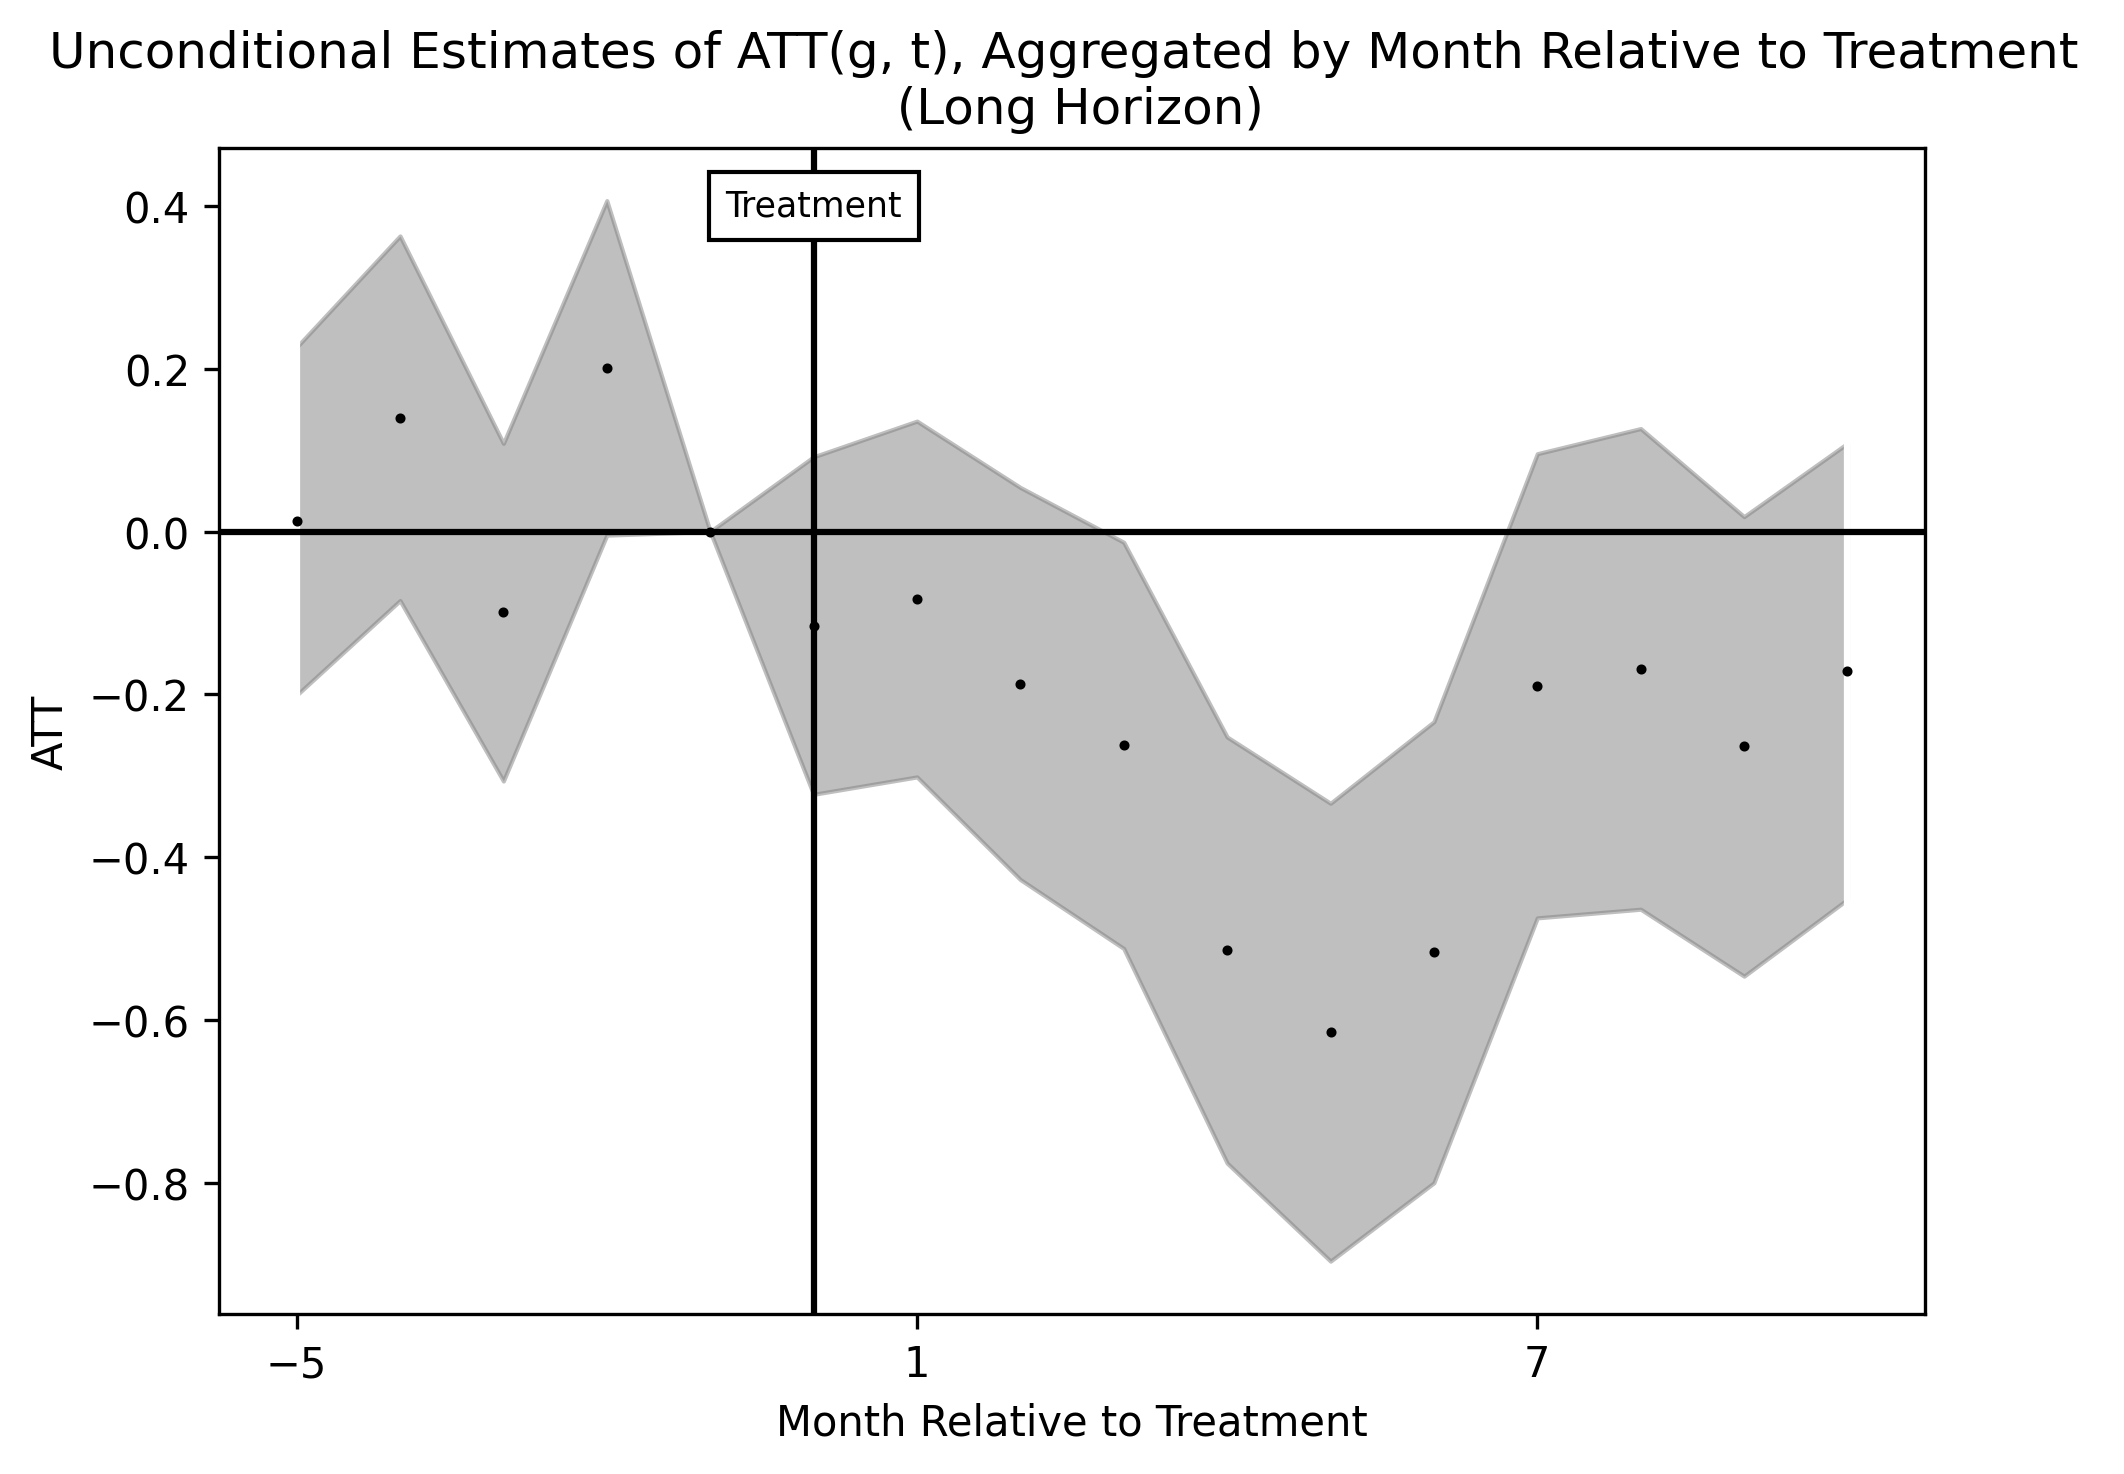

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-5, end_period=10,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

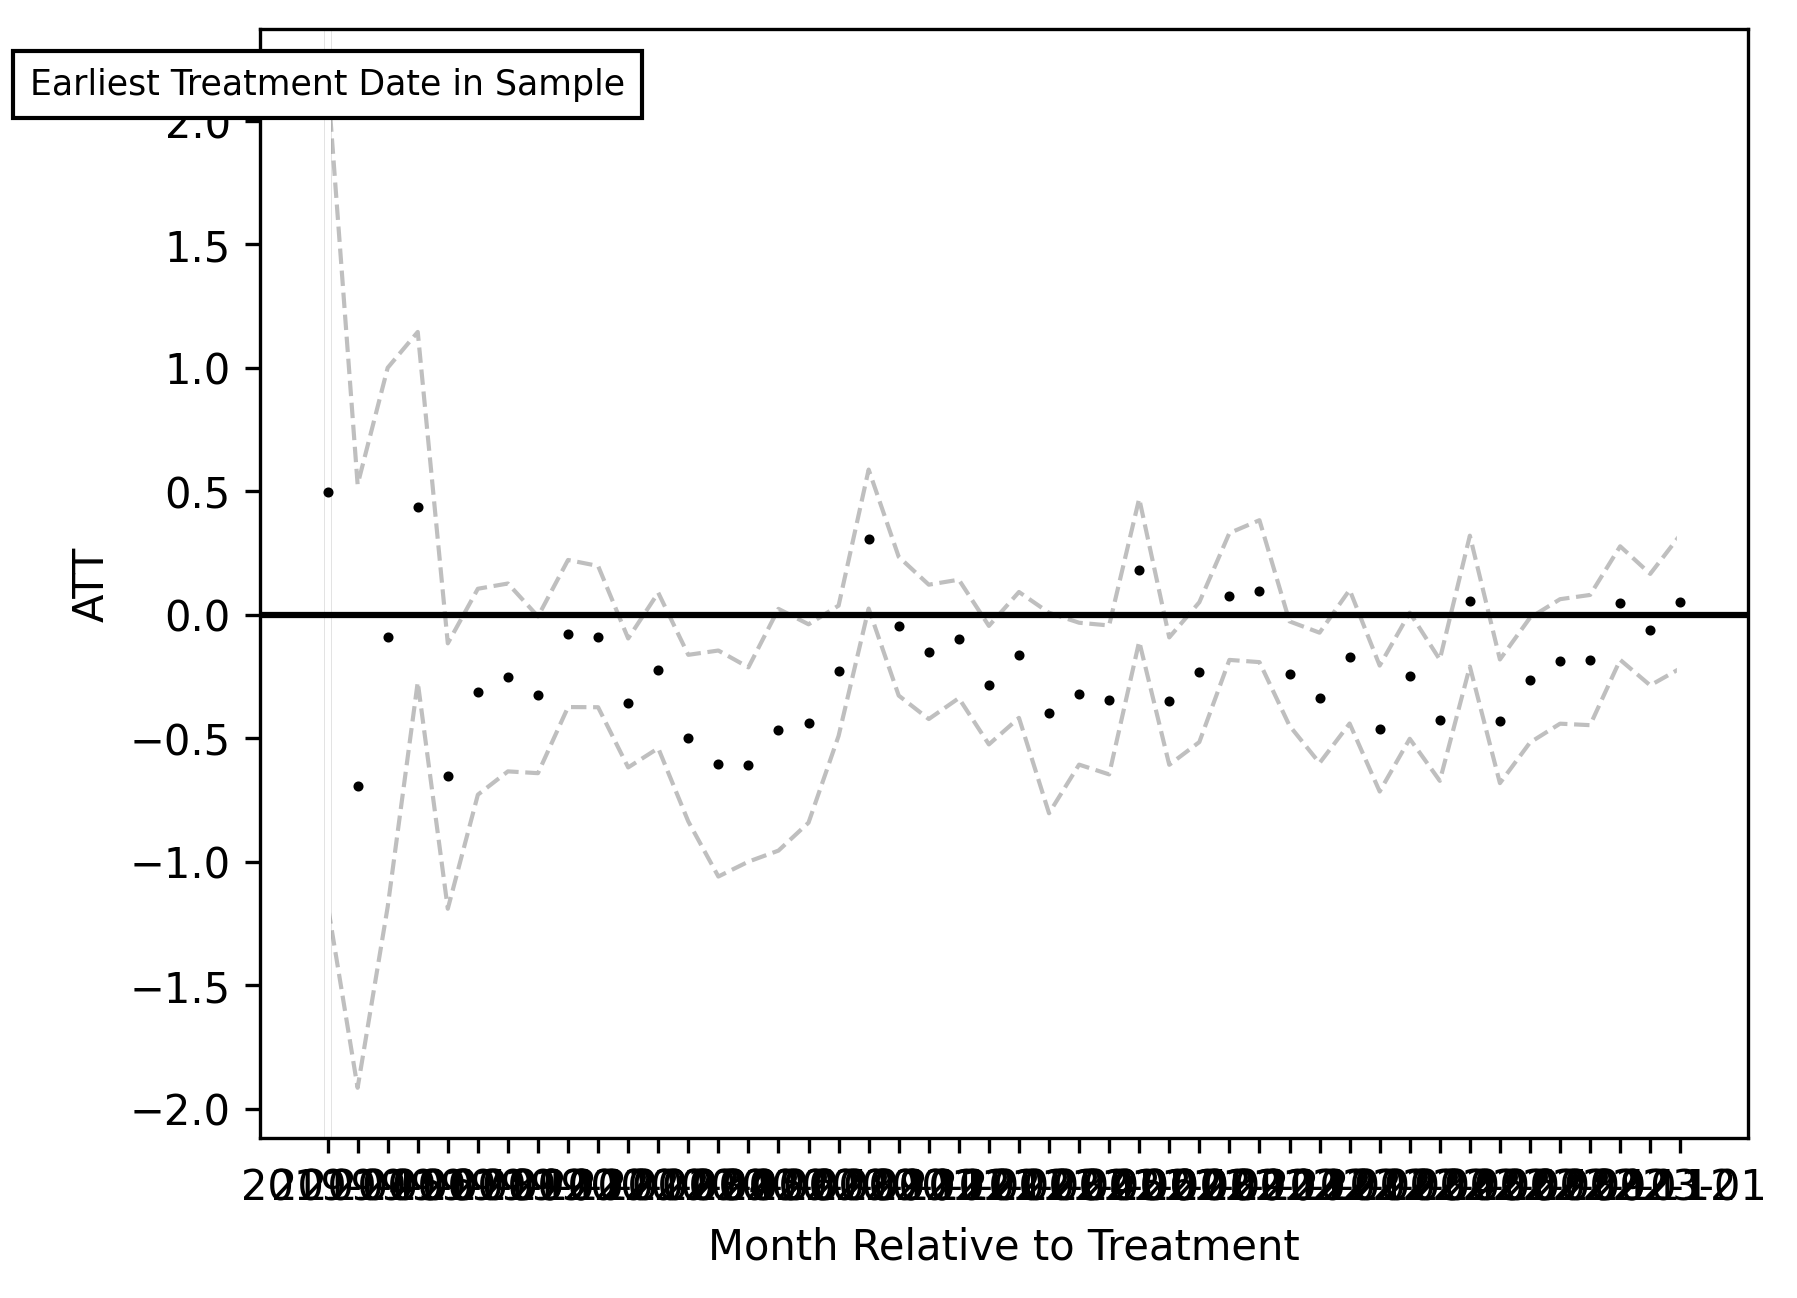

In [8]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=1, progress_bar=True)

Computing ATTgt [workers=1]   100%|████████████████████| 1104/1104 [00:17<00:00, 62.08it/s]


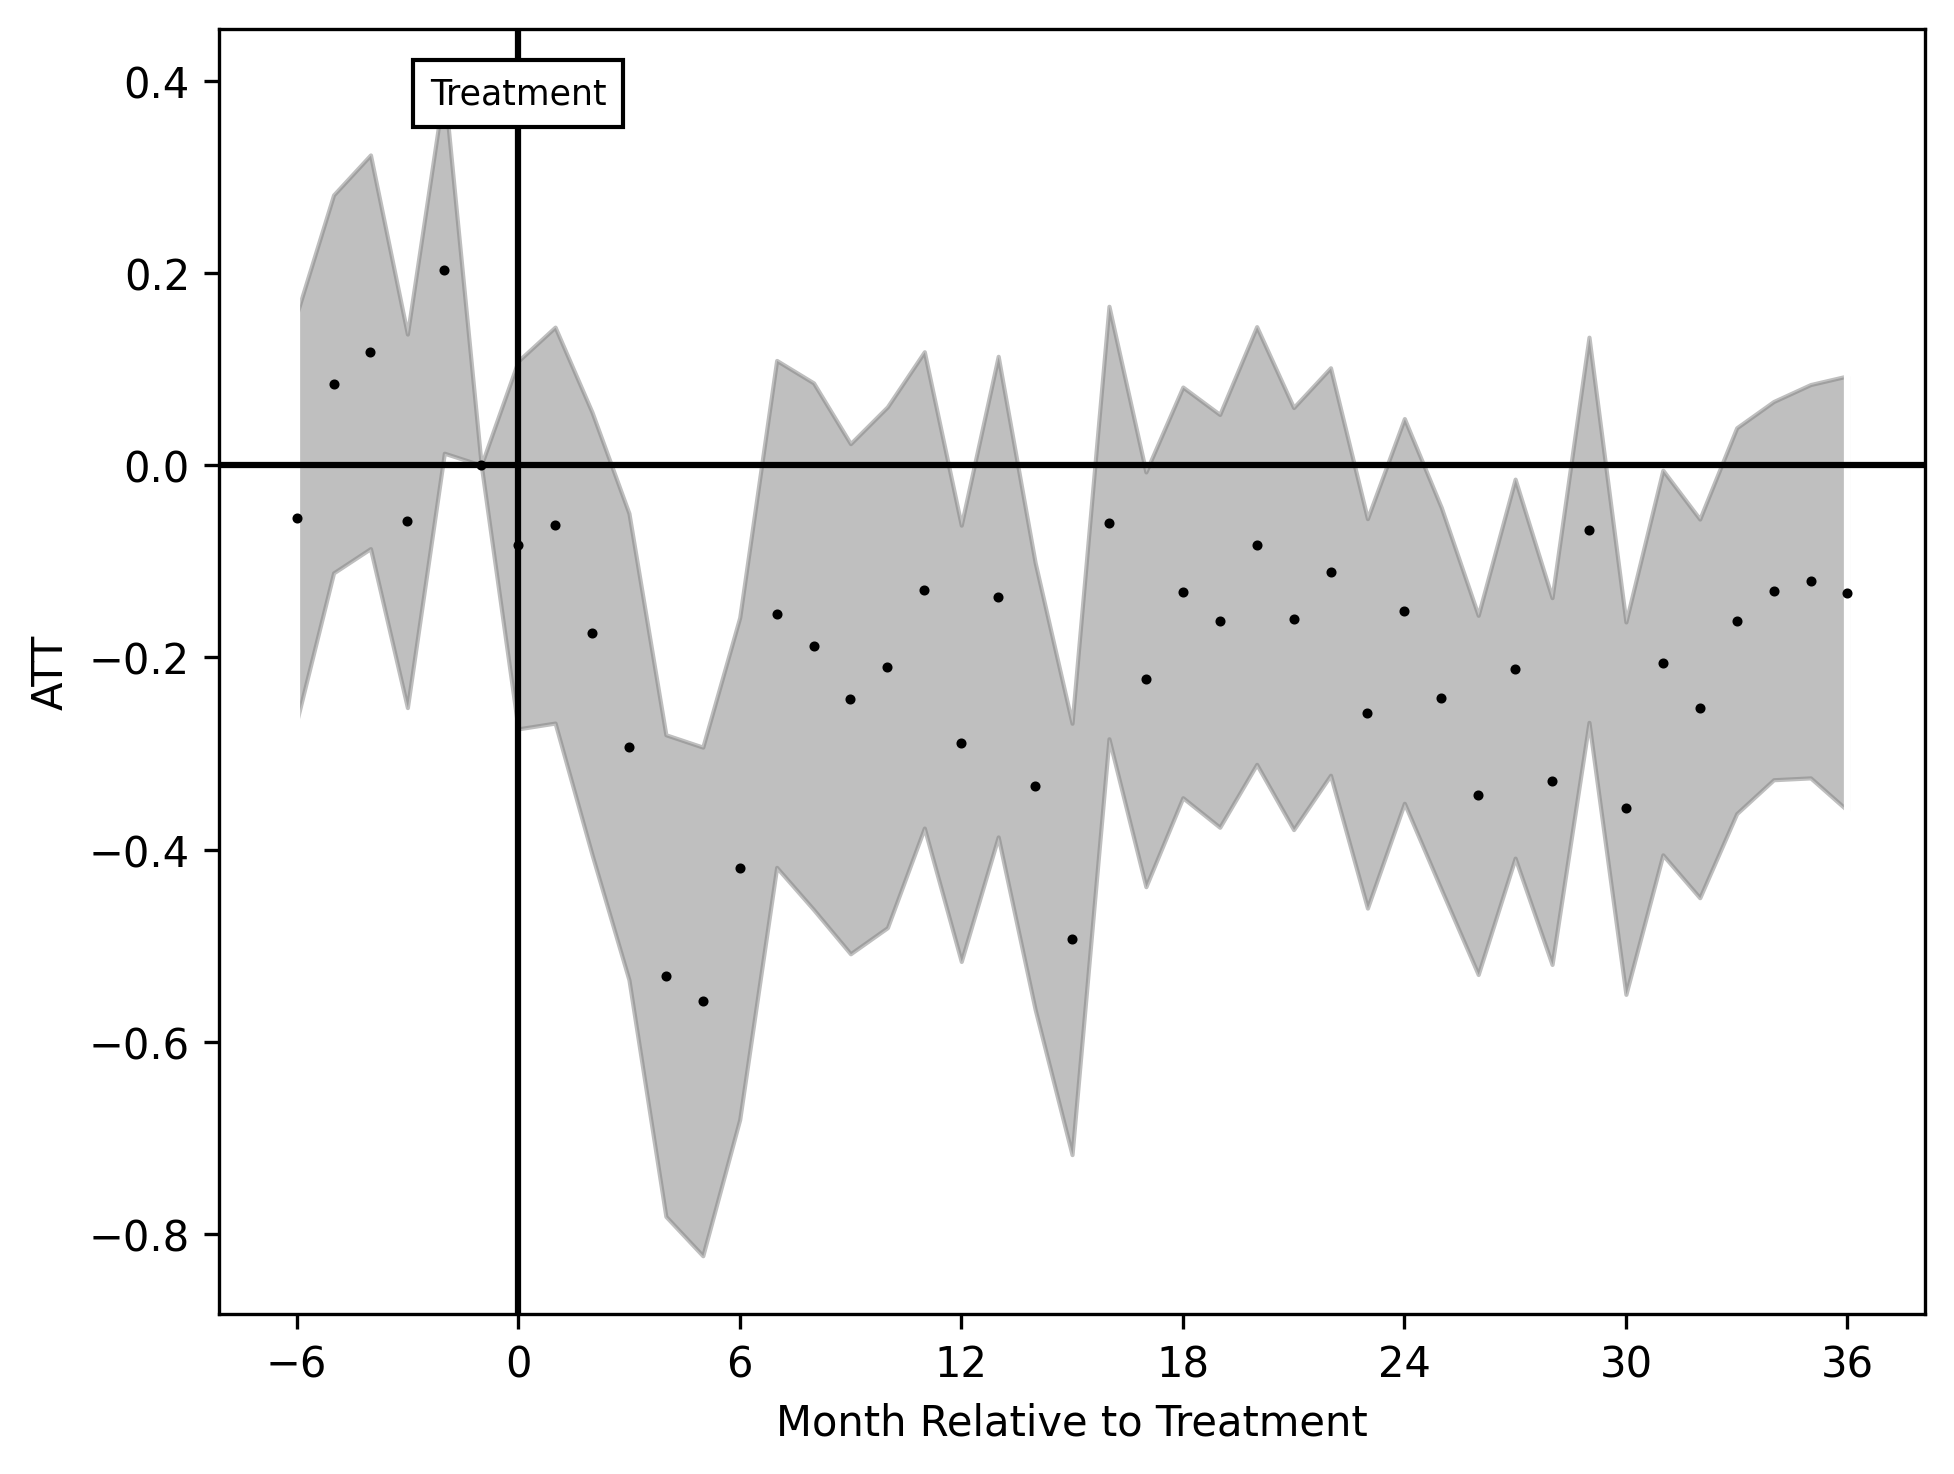

In [12]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

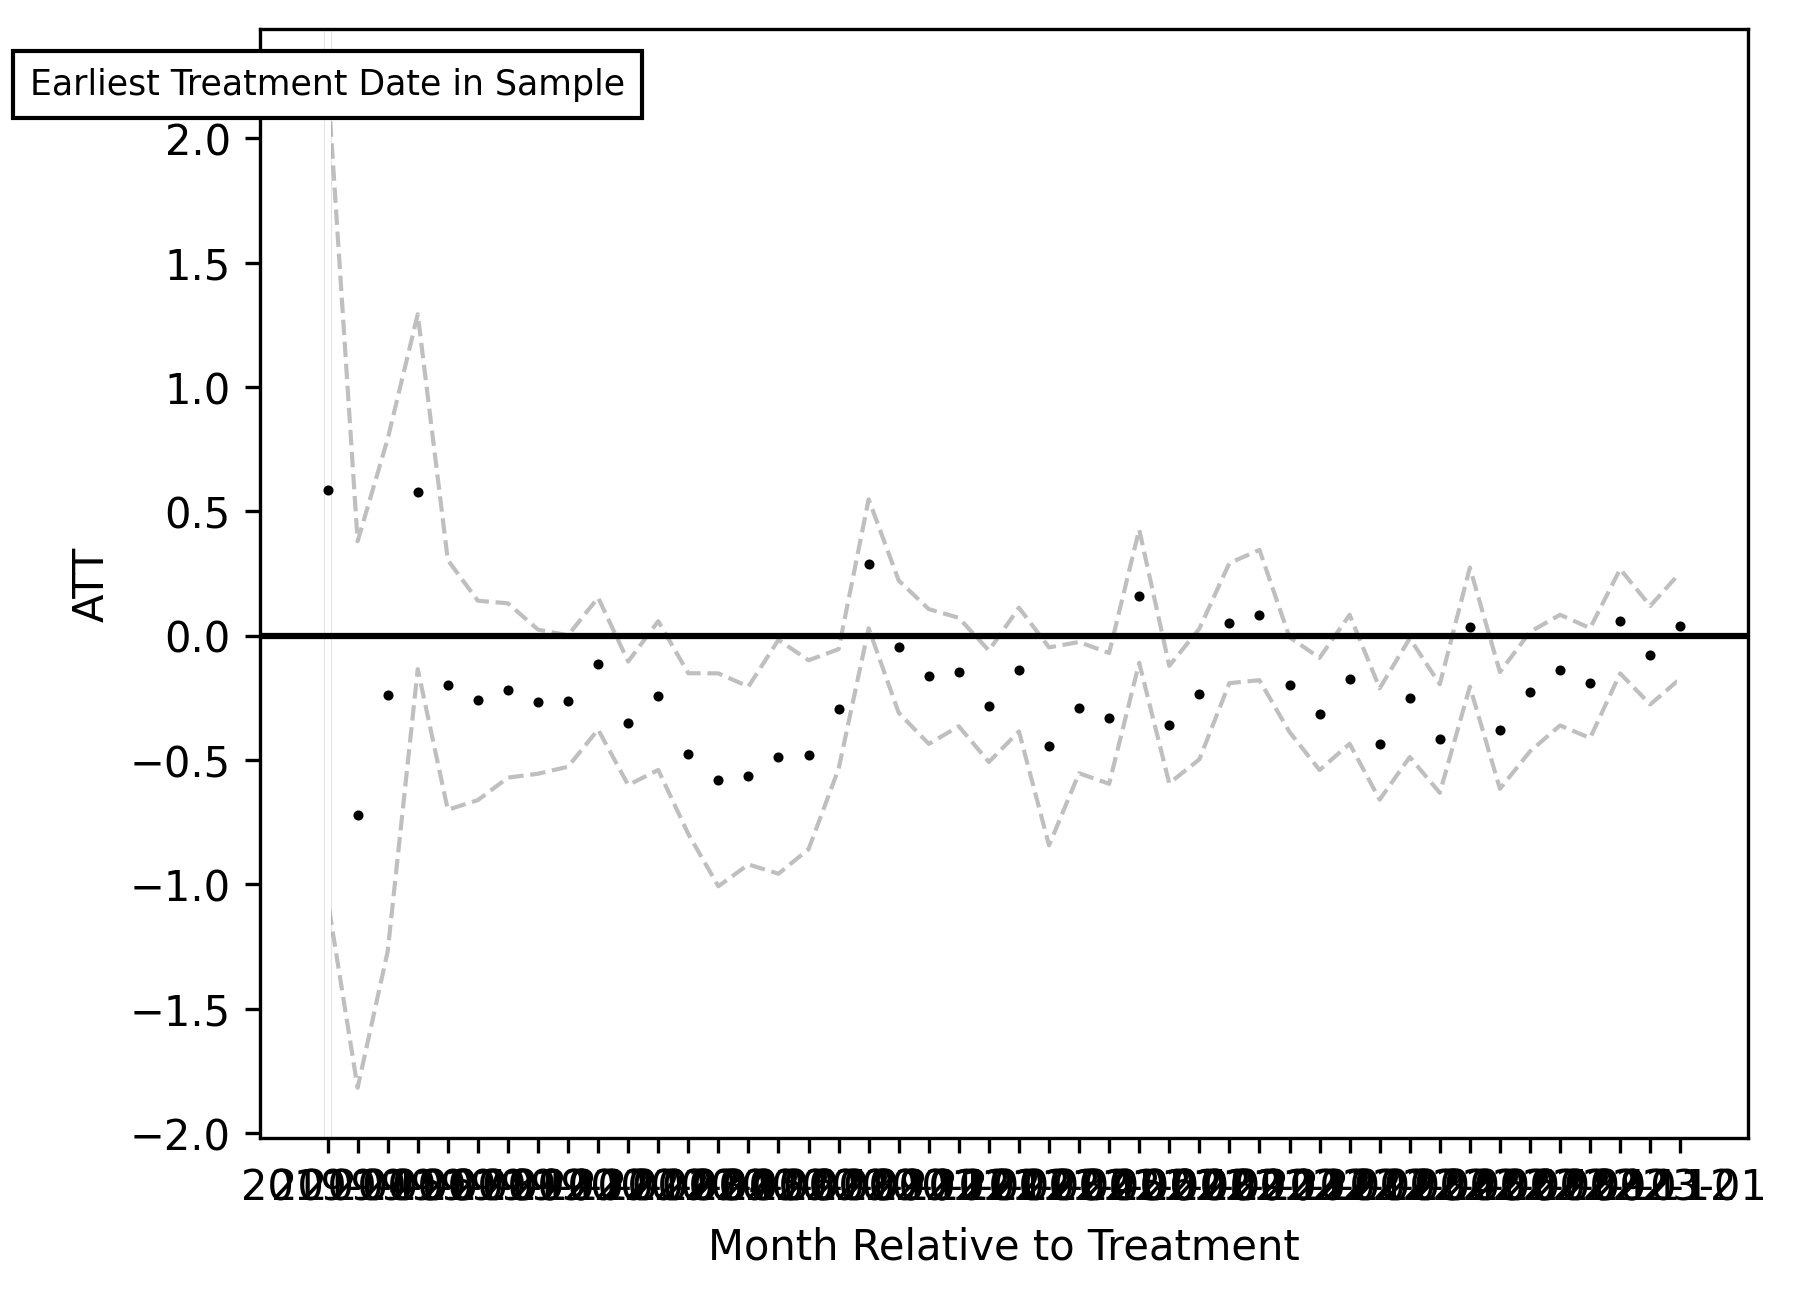

In [11]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")